# CS178 Project - Twitter Emoji Prediction

Group 69 - Chiang Krongapiradee, Arne Philipeit, Bryon Tjanaka

In [0]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

## Loading Data

In [0]:
# Upload data to Google Colab
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving Mapping.csv to Mapping.csv
Saving OutputFormat.csv to OutputFormat.csv
Saving Stems.csv to Stems.csv
Saving Test.csv to Test.csv
Saving Test2.csv to Test2.csv
Saving Train.csv to Train.csv
Saving Train2.csv to Train2.csv
Saving TweetStems.csv to TweetStems.csv
User uploaded file "Mapping.csv" with length 219 bytes
User uploaded file "OutputFormat.csv" with length 150 bytes
User uploaded file "Stems.csv" with length 2494653 bytes
User uploaded file "Test.csv" with length 2214023 bytes
User uploaded file "Test2.csv" with length 2188065 bytes
User uploaded file "Train.csv" with length 5780184 bytes
User uploaded file "Train2.csv" with length 5710184 bytes
User uploaded file "TweetStems.csv" with length 14930886 bytes


In [0]:
# Move and then list the files
!rm -rf data/twitter-emoji-prediction/*
!mkdir -p data/twitter-emoji-prediction
!cp *.csv -t data/twitter-emoji-prediction
!echo ".:"
!ls
!echo
!echo "data/twitter-emoji-prediction:"
!ls data/twitter-emoji-prediction

.:
data	     OutputFormat.csv  Stems.csv  Test.csv    Train.csv
Mapping.csv  sample_data       Test2.csv  Train2.csv  TweetStems.csv

data/twitter-emoji-prediction:
Mapping.csv	  Stems.csv  Test.csv	 Train.csv
OutputFormat.csv  Test2.csv  Train2.csv  TweetStems.csv


In [0]:
# Load the data into variables

mappings = {}
tweets = {}

mappings["original"] = pd.read_csv("data/twitter-emoji-prediction/Mapping.csv",
                         header=0, usecols=(1,))
tweets["original"] = pd.read_csv("data/twitter-emoji-prediction/Train2.csv",
                       header=0, usecols=(1,2), quotechar='"')
tweets["stems"] = pd.read_csv("data/twitter-emoji-prediction/Stems.csv",
                       header=0,usecols=(1,2),quotechar='\'')
tweets["tweet2stems"] = pd.read_csv("data/twitter-emoji-prediction/TweetStems.csv",
                       header=0, usecols=[i for i in range(2,91)], quotechar='"')

# Shuffle tweets
tweets["original"] = tweets["original"].sample(frac=1,
                            random_state=5).reset_index(drop=True)

# numpy versions of the data
mappings["data"] = mappings["original"].values
tweets["data"] = tweets["original"].loc[:,"TEXT"].values
tweets["stems"] = tweets["stems"].values
tweets["labels"] = tweets["original"].loc[:,"Label"].values
tweets["tweet2stems"] = tweets["tweet2stems"].values

In [0]:
# Mappings are the emoticons/emojis corresponding to each
# classification label.

mappings["original"]

,emoticons
0,😜
1,📸
2,😍
3,😂
4,😉
5,🎄
6,📷
7,🔥
8,😘
9,❤


In [0]:
# Tweets is the main data. It contains the text of each tweet and
# the label for it. The emoji corresponding to this label can be found
# above.

tweets["original"]

,TEXT,Label
0,#peas !!!!! Hoop house is looking yummy @user ...,17
1,It’s time to start rolling. mrkodykirk ....#br...,1
2,I love this musician @ Alewife Baltimore,3
3,What's on your mind today? Headphones are on m...,3
4,When you gota let your baby daddy know what it...,3
5,Great Christmas Service this morning! ️ @ Eagl...,9
6,Before the storms today #30A #duneallenbeach #...,14
7,New podcast computer loveeee. Link in bio and ...,7
8,Never gets old. @ Iowa State Capitol,16
9,Soooo How they let warriors come back from 23 ...,3


In [0]:
# Stems are generated with Apache OpenNLP.

tweets["stems"]

array([['<PAD>', '0'],
       ['"vacat"', '181'],
       ['"wast"', '18'],
       ...,
       ['"gali"', '1'],
       ['"666"', '1'],
       ['"asuram"', '1']], dtype=object)

In [0]:
# tweet2stems shows the sequence of stems in a given tweet, with
# padding added onto the end. This sequence is also generated with
# Apache OpenNLP.

tweets["tweet2stems"]

array([[   1,    2,    3, ...,    0,    0,    0],
       [  13,   14,   15, ...,    0,    0,    0],
       [  29,   30,   31, ...,    0,    0,    0],
       ...,
       [1653,  312,   71, ...,    0,    0,    0],
       [1971,  324, 7959, ...,    0,    0,    0],
       [  40,   47,   16, ...,    0,    0,    0]])

# Simple Analysis

### Preliminary Data Analysis

Some data analysis done with pure Python, to get a sense for some common words, hashtags, and emojis in the data set.

In [0]:
def print_most_common(counts: {str: int}, exclude: {str}, n=20):
  """Prints the n words with the most counts in the given data"""
  for word, c in sorted(counts.items(), key=lambda x: (-x[1], x[0])):
    if word not in exclude:
      print(f"{word}: {c}")
      n -= 1
    if n == 0: break

def count_words_beginning_with(char: str) -> {str: int}:
  """Count words beginning with the given character"""
  counts = defaultdict(int)
  for text in tweets["data"]:
    text = text.lower()
    text = "".join(a for a in text if a.isalpha() or a.isnumeric() or \
                                      a.isspace() or a == char)
    for word in text.split():
      if word[0] == char:
        counts[word] += 1
  return counts

In [0]:
# Count up occurrences of each word -
# only take into account alphanumeric characters
word_counts = defaultdict(int)
for text in tweets["data"]:
  text = text.lower()
  text = "".join(a for a in text if a.isalpha() or a.isnumeric() or \
                                    a.isspace())
  for word in text.split():
    word_counts[word] += 1

# "amp" is |&amp;|, i.e. ampersand
# "user" is usually part of |@user|
common_words = {"the", "i", "my", "a", "to", "and", "in", "you", "of", "for",
                "with", "this", "is", "at", "on", "so", "was", "your", "from",
                "we", "be", "it", "by", "me", "im", "are", "that", "our",
                "just", "its", "these", "but", "amp", "user"}

print_most_common(word_counts, common_words)

love: 5677
new: 4694
happy: 3386
day: 3052
all: 2366
out: 2098
one: 2048
york: 2010
night: 2008
time: 1979
beach: 1921
when: 1911
today: 1893
have: 1891
good: 1875
park: 1834
up: 1813
christmas: 1803
best: 1778
like: 1690


In [0]:
# Extract hashtags
hashtags = count_words_beginning_with('#')
print(f"{len(hashtags)} hashtags")
print_most_common(hashtags, set())

38714 hashtags
#love: 530
#repost: 515
#tbt: 501
#nyc: 471
#: 362
#family: 293
#usa: 267
#newyork: 232
#christmas: 184
#california: 176
#nofilter: 159
#wcw: 148
#chicago: 140
#miami: 137
#losangeles: 133
#mcm: 132
#travel: 124
#la: 118
#photography: 117
#blessed: 116


In [0]:
# Extract mentions
mentions = count_words_beginning_with('@')
print(f"{len(mentions)} mentions")
print_most_common(mentions, set(), 21)

313 mentions
@: 39466
@user: 16355
@princehobson: 4
@woridstarhiph0p: 3
@wshhfans: 3
@babyanimalpics: 2
@blakeshelton: 2
@camerondallas: 2
@commonwhitegrls: 2
@thefunnyvine: 2
@worldstarfunny: 2
@xpeesx: 2
@1future: 1
@1oaklv: 1
@30secondflghts: 1
@84footwork: 1
@abbyykaitlyn: 1
@acmeandco: 1
@adambsutton: 1
@adamlevine: 1
@adivanrheenen: 1


In [0]:
# Count up ascii emojis

emojis = {":)" : 0, ":D" : 0, ";)": 0, ":p" : 0, "XD" : 0, 
          ":o" : 0, ":(" : 0}
for text in tweets["data"]:
  for e in emojis:
    emojis[e] += text.count(e)

print(emojis)

{':)': 96, ':D': 3, ';)': 24, ':p': 8, 'XD': 3, ':o': 0, ':(': 8}


Counts and Indices
😜(0): 1557
📸(1): 2592
😍(2): 7076
😂(3): 6842
😉(4): 1878
🎄(5): 1977
📷(6): 2083
🔥(7): 4363
😘(8): 1992
❤(9): 15091
😁(10): 1721
🇺🇸(11): 2434
☀(12): 1909
✨(13): 3250
💙(14): 2342
💕(15): 3843
😎(16): 2832
😊(17): 2751
💜(18): 1722
💯(19): 1745


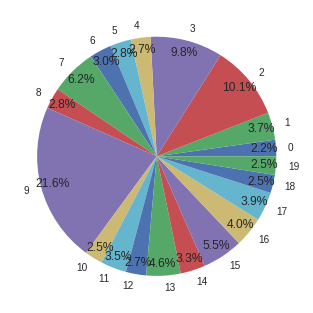

In [0]:
# Count up the number of occurrences of each emoji

emoji_counts = np.zeros(len(mappings["original"]), dtype=int)

for e in tweets["labels"]:
    emoji_counts[e] += 1

# Pie chart has to display indices because we could not find a font that
# supports the emojis.
plt.pie(emoji_counts, labels=[i for i in range(len(emoji_counts))],
        autopct='%1.1f%%', pctdistance=0.9);

print("Counts and Indices")
for i in range(len(emoji_counts)):
  print(f"{mappings['data'][i,0]}({i}): {emoji_counts[i]}")

### Correlations in stems

Essentially, we want to know what the most common emojis are for tweets with each stem. Then, we want to see if we can use this data on common emojis to predict the emoji of a tweet by looking for the most common emoji associated with the stems in the tweet.

In [0]:
# Value used for padding
PAD = 0

In [0]:
def num_to_emoji(x: int):
  return mappings['data'][x]

In [0]:
def count_emojis_per_stem(idx: int):
  """
  Counts, for each stem, the number of tweets with emojis of each type.
  Only counts among tweets in the range [0, idx)
  """
  counts = np.zeros((len(tweets["stems"]), len(mappings["data"])),
                    dtype=int)
  i = 0
  for tweet, label in zip(tweets["tweet2stems"], tweets["labels"]):
    if i == idx: break
    stems = set(tweet)
    for s in stems:
      counts[s,label] += 1
  
  return counts

popular = np.argmax(count_emojis_per_stem(70000), axis=1)

for i in range(len(popular)):
  print(f"{tweets['stems'][i,0]}: {num_to_emoji(popular[i])}")

<PAD>: ['❤']
"vacat": ['❤']
"wast": ['😂']
"!": ['❤']
"2017": ['❤']
"photobomb": ['😂']
"tire": ['😍']
"vacationwast": ['😊']
"mcgar": ['😊']
"30": ['❤']
"miami": ['❤']
"port": ['❤']
"…": ['❤']
"oh": ['❤']
"wynwood": ['❤']
": ['❤']
"you": ['❤']
"’": ['❤']
"re": ['❤']
"so": ['❤']
"funni": ['❤']
":": ['❤']
"user": ['❤']
"art": ['❤']
"itwa": ['📸']
"3": ['❤']
"am": ['❤']
"flower": ['❤']
"vibe": ['❤']
"been": ['❤']
"friend": ['❤']
"sinc": ['❤']
"7": ['❤']
"th": ['❤']
"grade": ['❤']
".": ['❤']
"look": ['❤']
"at": ['❤']
"us": ['❤']
"now": ['❤']
"we": ['❤']
"all": ['❤']
"follow": ['❤']
"our": ['❤']
"dream": ['❤']
"do": ['❤']
"what": ['❤']
"love": ['❤']
"and": ['❤']
"this": ['❤']
"like": ['❤']
"when": ['❤']
"someon": ['❤']
"uncondit": ['❤']
"puppi": ['❤']
"brother": ['❤']
"htx": ['😂']
"rt": ['❤']
"white": ['❤']
"famili": ['❤']
"was": ['❤']
"invit": ['❤']
"to": ['❤']
"black": ['❤']
"barbecu": ['🔥']
"i": ['❤']
"'": ['❤']
"ve": ['❤']
"never": ['❤']
"laugh": ['❤']
"hard": ['❤']
"my": ['❤']
"life": ['❤']

### Bayesian Predictor

Predictions of tweets using Bayesian analysis. Each tweet is seen as consisting of independent words, excluding padding. The probability of a certain emoji for the tweet is taken as

$$P(emoji | tweet_j) = \prod_{i = 1}^{n_j} P(emoji | stem_i)$$

Where $n_j$ is the number of stems in $tweet_j$ (excluding padding), and $P(emoji | stem_i)$ is the probability that a tweet will be assigned a certain emoji given that it contains a certain stem.

The predicted emoji is simply the one with the highest probability.

We calculated probabilities $P(emoji | stem_i)$ by looking only at stems in a training set consisting of the first 60000 tweets. Then, we used the last 10000 as a testing set.

In [0]:
import functools
import operator

def predict_bayesian(stems, p_emoji_stem) -> int:
  """
  Using the given conditional probabilities, predicts the most
  likely emoji for a given tweet using the Bayesian classifier
  """
  p_emoji_tweet = np.zeros(len(mappings["data"]), dtype=float)
  for emoji in range(len(p_emoji_tweet)):
    p_emoji_tweet[emoji] = \
      functools.reduce(operator.mul,
                       [p_emoji_stem[stem, emoji] for stem \
                        in stems if stem != PAD])
  return np.argmax(p_emoji_tweet)

TRAIN_SIZE = 60000
TEST_SIZE = len(tweets["labels"]) - TRAIN_SIZE # 10000

# Calculate the conditional probability of each emoji corresponding to a given
# tweet for each given stem.
counts = count_emojis_per_stem(TRAIN_SIZE)
totals = np.sum(counts, axis=1)
trained_p_emoji_stem = counts / np.vstack([totals] * counts.shape[1]).T

# Make predictions on training data
training_predictions = np.zeros(TRAIN_SIZE, dtype=int)
for j in range(TRAIN_SIZE):
  training_predictions[j] = predict_bayesian(tweets["tweet2stems"][j,:],
                                             trained_p_emoji_stem)

# Make predictions on testing data
testing_predictions = np.zeros(TEST_SIZE, dtype=int)
for j in range(TEST_SIZE):
  testing_predictions[j] = predict_bayesian(
      tweets["tweet2stems"][j + TRAIN_SIZE,:], trained_p_emoji_stem)
  
print(training_predictions.shape)
print(testing_predictions.shape)

(60000,)
(10000,)


In [0]:
# Sample outputs
for i in range(5):
  print(f"{tweets['data'][i]} --- {num_to_emoji(training_predictions[i])}")

#peas !!!!! Hoop house is looking yummy @user @user @user @user --- ['❤']
It’s time to start rolling. mrkodykirk ....#brentgee #progressivehouse #techhouse… --- ['💕']
I love this musician @ Alewife Baltimore --- ['❤']
What's on your mind today? Headphones are on my mind right now. @ Good Day Columbus --- ['😎']
When you gota let your baby daddy know what it is starring realmeladonna and I#fatboygang… --- ['💯']


In [0]:
# Zero-one error rate
correct_training = sum(tweets["labels"][:TRAIN_SIZE] == training_predictions)
correct_testing = sum(tweets["labels"][TRAIN_SIZE:] == testing_predictions)
print("Training")
print(f"Total   : {TRAIN_SIZE}")
print(f"Correct : {correct_training}")
print(f"Wrong   : {TRAIN_SIZE - correct_training}")
print(f"Accuracy: {correct_training / TRAIN_SIZE}")
print()
print("Testing")
print(f"Total   : {TEST_SIZE}")
print(f"Correct : {correct_testing}")
print(f"Wrong   : {TEST_SIZE - correct_testing}")
print(f"Accuracy: {correct_testing / TEST_SIZE}")

Training
Total   : 60000
Correct : 37885
Wrong   : 22115
Accuracy: 0.6314166666666666

Testing
Total   : 10000
Correct : 6289
Wrong   : 3711
Accuracy: 0.6289


# Complicated Analysis

Tinkering around with Keras/Tensorflow, model training

In [0]:
# Mapping between each tweet and stem
# Eliminate the common stems
# Turn into sparse vectors of length 67000 - tells whether each stem occurs
# Take the vectors of 67000 and feed them into the neural net
# Out comes a softmax that classifies between the 20 emojis
# start with just a few hundred to test memory limits

tweets["selected_tweet2stems"] = tweets["tweet2stems"]
tweets["selected_labels"] = tweets["labels"]

vocab_size = np.max(tweets["selected_tweet2stems"]) + 1
label_size = np.max(tweets["selected_labels"]) + 1   
vec_size = tweets["tweet2stems"].shape[1]

print("vocab size: %d" % vocab_size)
print("label size: %d" % label_size)
print("  vec size: %d" % vec_size)

vocab size: 66188
label size: 20
  vec size: 89


In [0]:
x_val = tweets["selected_tweet2stems"][60000:]
partial_x_train = tweets["selected_tweet2stems"][:60000]

y_val = tweets["selected_labels"][60000:]
partial_y_train = tweets["selected_labels"][:60000]

In [0]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 128))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(128, activation=tf.nn.relu))
model.add(keras.layers.Dense(label_size, activation=tf.nn.softmax))

model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=32,
                    steps_per_epoch=20,
                    validation_data=(x_val, y_val),
                    validation_steps=5,
                    verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_54 (Embedding)     (None, None, 128)         8472064   
_________________________________________________________________
global_average_pooling1d_54  (None, 128)               0         
_________________________________________________________________
dense_109 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_110 (Dense)            (None, 20)                2580      
Total params: 8,491,156
Trainable params: 8,491,156
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
20/20 [==============================] - 60s 3s/step - loss: 2.9338 - acc: 0.2077 - val_loss: 2.8565 - val_acc: 0.2076
Epoch 2/10
20/20 [==============================] - 59s 3s/step - loss: 2.7751 - acc: 0.2169 - val_loss: 2.7634 - val_acc: 0.2076
Epoc

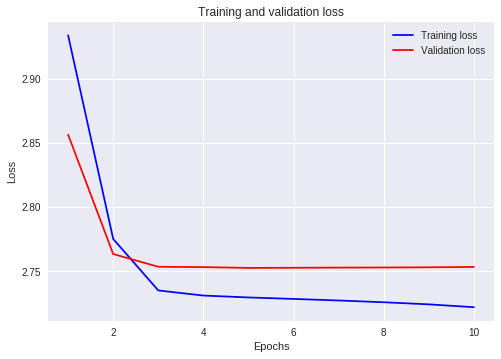

In [0]:
history_dict = history.history
history_dict.keys()

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'b', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

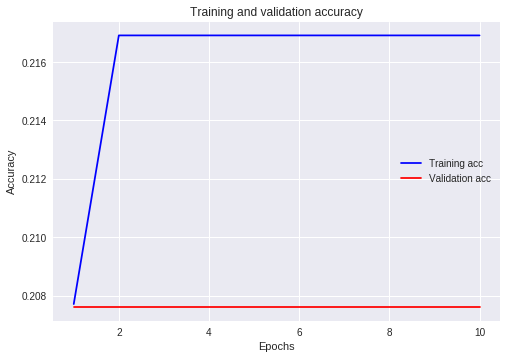

In [0]:
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [0]:
predictions = model.predict(tweets["tweet2stems"])

print(predictions[420])

[0.02183113 0.0367145  0.10221115 0.09786906 0.02627915 0.02812979
 0.02950468 0.06247859 0.02836072 0.21866922 0.02442348 0.03387608
 0.02698527 0.04570885 0.03349717 0.05497511 0.04024656 0.03910059
 0.02424962 0.02488921]


In [0]:
def predict_emoji(stems):
  """Given the stems in a tweet, makes a prediction about it"""
  prediction = model.predict(np.atleast_2d(stems))
  return num_to_emoji(np.argmax(prediction))

print(predict_emoji(tweets["tweet2stems"][420,:]))

['❤']


64411: Wouldn't wanna do life with anyone else @ Hat Tricks


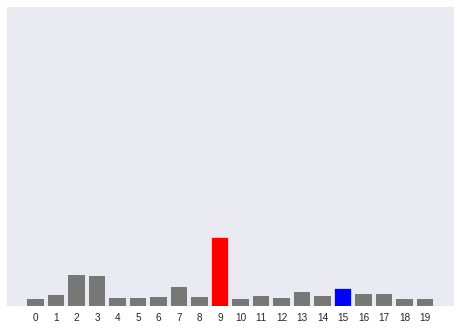

17546: In a love-hate relationship with last night. Love the people ️…


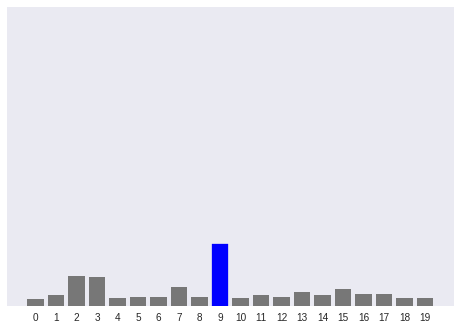

39418: @user you got the wrong professor. I can't with you. Is he hard?


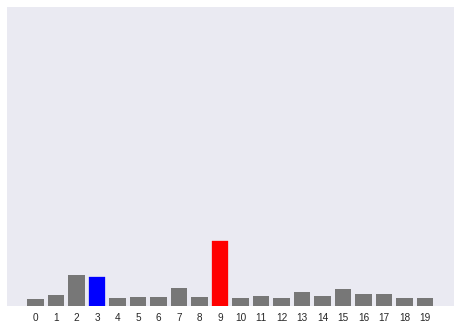

23313: #morninglibations #cheers #wheninboston @ Stephanie's On Newbury


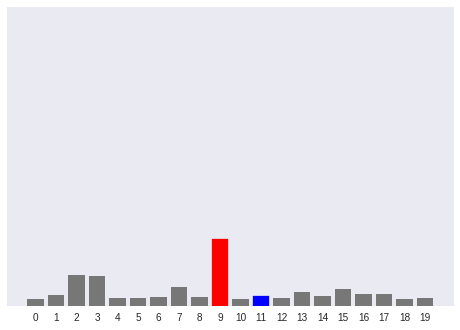

65550: Man its fri smile @ On a Roll Baby Catering


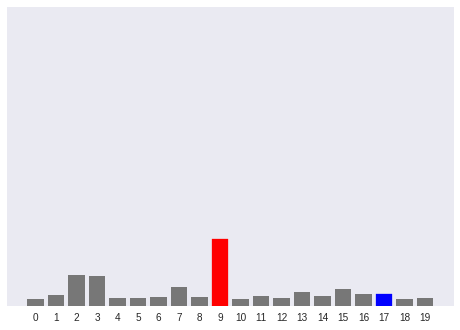

In [0]:
def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([i for i in range(20)])
  plt.yticks([])
  thisplot = plt.bar(range(20), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

for i in np.random.randint(tweets["tweet2stems"].shape[0], size=5):
  print("%d: " % i + tweets["original"].values[i][0])
  plt.figure()
  plot_value_array(i, predictions, tweets["labels"])
  plt.show()